In [1]:
import requests
import os

# 아래 url은 yahoo finance 서버에 우리나라 코스피 데이터를 요청하는 주소입니다.
url = "https://query1.finance.yahoo.com/v7/finance/download/%5EKS11?period1=867715200&period2=1597276800&interval=1d&events=history"

# 데이터를 요청하고 그 결과를 response로 받습니다.
response = requests.get(url)

csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/kospi.csv'

# response 의 컨텐츠를 csv로 저장합니다.
with open(csv_file, "w") as fp:  
    fp.write(response.text)

In [2]:
# 저장한 csv를 읽어옵니다.
import pandas as pd
df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-07-01,744.979980,760.520020,744.669983,758.030029,758.030029,0.0
1,1997-07-02,763.390015,777.289978,763.390015,777.289978,777.289978,0.0


In [3]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date           0
Open         150
High         150
Low          150
Close        150
Adj Close    150
Volume       150
dtype: int64

어이쿠 결측치가 있는 날짜가 150개나 되네요. 이대로 내버려두면 모델에서 예상치 못한 오류가 발생할 수 있어요.   
이렇게 분석 시계열 데이터에 결측치가 있다면 어떻게 해야 할까요? 결측치 주변의 데이터를 이용해서 보간(interpolation)하거나, 삭제하는 방법을 생각해 볼 수 있겠죠? 하지만 여러분들은 결측치를 다루는 방법을 이미 공부한 적이 있을 테니, 평균값 등 통계치를 사용하거나 다른 분포를 활용해 예측하는 등 다양한 방법이 있다는 것도 알고 있을 것입니다.

In [4]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 5842
삭제 후 데이터 길이(일자수): 5692


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Data visualisation

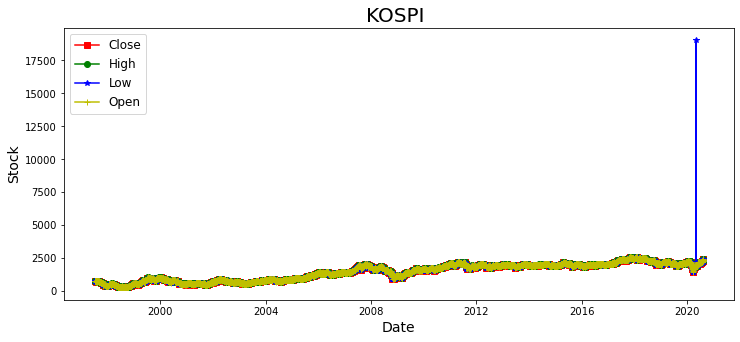

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

In [6]:
df.loc[df.Low > df.High]

,Date,Open,High,Low,Close,Adj Close,Volume
5620,2020-05-06,1919.449951,1928.76001,19025.550781,1928.76001,1928.76001,1082200.0


### 1. Outlier 교정

In [ ]:
# 카카오 주식차트 결과로 대체합니다. 
df.loc[df.Date == '2020-05-06', 'Low'] = 1903 

# 비정상데이터가 제거되었는지 다시 확인해 봅니다.
df.loc[df.Low>df.High]

In [ ]:
### 2. Anomaly 교정

Anomaly는 보통 교정을 하지않음.

# z-test : 우리 데이터는 정규분포일까?

In [ ]:
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(-5, 5, 0.001)
y = norm.pdf(x,0,1) 
# 평균이 0이고, 표준편차가 1인 정규분포를 그립니다.

# build the plot
fig, ax = plt.subplots(figsize=(9,6))
ax.fill_between(x,y,0, alpha=0.3, color='b')
ax.set_xlim([-4,4])
ax.set_title('normal distribution')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

한눈에 봐도 딱 정규분포와는 거리가 먼 분포네요… 가운데가 전혀 볼록하지 않아요. 하지만 직관이 아닌 숫자로 판단해봅시다!   

단변수의 정규분포 여부는 z-test 방법으로 확인할 수 있어요.

In [ ]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

p가 0.05 이하로 나왔으면 normal distribution과 거리가 멀다는 뜻이에요.   
즉, 이런 데이터로는 '정규분포'를 가정한 통계적 추정이 어려워요   
그렇다면 이 데이터에 대해서는 정규분포를 가정한 신뢰구간 분석은 적용하기 어려울 것입니다.   

# 시계열 데이터 중에서 정규분포에 가까운 데이터를 뽑아내는 방법 : Time series decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result.plot()
plt.show()

In [ ]:
#그래프가 너무 작아서 안보인다면

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

In [ ]:
# seasonal 성분은 너무 빼곡하게 보이네요. 다시 확인해보겠습니다.
result.seasonal[:100].plot()
#-8 에서 10 사이를 주기적으로 반복하는게 보이네요.

우리는 Time series decompose 결과에서 무엇을 알수 있나요?:   
우리는 정규분포에서 표준편차를 이용한 이상치 인식을 사용하고 싶었어요   
추세Trend 와 계절적 성분Seasonal을 뽑아내고 남은 잔차Residual를 볼까요?   
잔차는 평균 0을 기준으로 분포하고 있어요!   
잔차가 큰 날은 뭔가 일반적인 추세나 계절성에서 벗어난 날로 해석되겠죠?   
그럼 Residual의 분포를 그려보도록 하겠습니다   

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [ ]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

## 3σ 기준 신뢰구간으로 이상치 찾기

In [ ]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

In [ ]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

## 데이터 전처리

In [ ]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

In [ ]:
rdf.describe()

In [ ]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

## Clustering 1: k-means 로 이상치 탐색하기

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

In [ ]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

여러분들은 분류 결과가 어떻게 나왔나요? 저의 경우 3,9,10번 그룹의 경우 그룹 내 count가 10개 이내로 분류된 매우 특이한 그룹으로 분류되었습니다.

특이그룹 번호는 여러분들의 수행 결과에 따라 다를 수 있습니다. 그러나 이렇게 특이하게 분류된 그룹에 속한 데이터의 경우 유사한 날들이 거의 없다는 뜻이므로 우리가 찾고 있는 이상치로 볼수 있습니다.

다음 활동을 통해 이상치를 분석해 보겠습니다.

어떤 날들이 분류된건지
각 그룹은 어떤 특징을 갖고 있는지
왜 이상치로 분류된걸까?   

✔️1. 어떤 날들이 분류된건지 (원본 코스피 데이터에서 탐색)

In [ ]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==3)|(kmeans.labels_==8)|(kmeans.labels_==12)]

In [ ]:
df.describe()

In [ ]:
# 2004-04-14 주변 정황
df.iloc[1660:1670]

✔️2. 각 그룹은 어떤 특징을 갖고 있는지

In [ ]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

In [ ]:
다른 그룹들은 거래량 값이 매우 작지만, 2개 그룹의 거래량 수치가 유독 큽니다. 저의 경우 3,10번 그룹이 이 경우입니다.
그리고 Open, High, Low, Close의 값이 유독 낮은 그룹이 하나 있습니다. 저의 경우 9번 그룹이 이 경우입니다.

✔️3. 왜 이상치로 분류된걸까?

3번 10번 그룹의 거래량은 비정상적입니다.
df.describe()로 알아본 전체 평균거래량은 4,329,776이에요

그런데 3번 10번 그룹은 거래량이 250,000,000 이상으로 평균 대비 60배 이상 많아요.

한번 인터넷 검색으로 이 값들이 맞는지 확인해볼까요??

(적합한 사이트를 찾기 어렵다면 링크를 활용해주세요)

확인 결과 우린 다시한번 야후 파이낸스의 실수를 찾아냈어요.

3번 10번 그룹의 거래량은 나누기 1000을 해야 정상적인 값이 됩니다.

9번 그룹은 각 그룹의 특징에서 답을 찾을수 있었어요.
슬프게도 코스피 역사상 가장 큰 폭락장이었던 날입니다.

In [ ]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

## Clustering 2: DBSCAN 으로 이상치 찾기

In [ ]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

In [ ]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

In [ ]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

## Forecasting: Auto-Encoder를 이용한 이상치 탐색

In [ ]:
# 필요한 라이브러리를 불러옵니다

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

### LSTM 을 이용한 오토인코더 모델 만들기

In [ ]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [ ]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

In [ ]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

In [ ]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [ ]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

In [ ]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [ ]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 3
test_df.loc[test_df.Loss>threshold]

In [ ]:
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

In [ ]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])